<a href="https://colab.research.google.com/github/DajanaSanchez/BirdMigrationClimateAnalysis/blob/main/climate_ensemble_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#read merged_bird_climate.parquet
import pandas as pd
df = pd.read_parquet('/content/drive/MyDrive/final_merged_dataset.parquet')

In [ ]:
#SEASON MAPPING
def month_to_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

df["Season"] = df["Month"].apply(month_to_season)

In [ ]:
df.sample(5)

,Latitude,Longitude,Observation_Date,Year,Region,Land_Cover_Description,Has_Habitat_Change,Temp_celsius,Precip_mm,Month,Season
4913873,41.626520,-83.188969,2022-05-01,2022,US,Water,False,18.67,85.7,5,Spring
655214,39.267082,-75.469551,2009-05-01,2009,US,Croplands,False,18.75,143.4,5,Spring
2142751,39.550250,-76.646891,2011-08-01,2011,US,Savannas,False,26.44,304.1,8,Summer
3689541,40.971088,-97.006100,2020-03-01,2020,US,Croplands,False,6.85,42.5,3,Spring
3596100,39.465000,-74.447778,2023-06-01,2023,US,Woody Savannas,True,20.00,65.5,6,Summer


In [ ]:
df.describe()

,Latitude,Longitude,Observation_Date,Year,Temp_celsius,Precip_mm,Month
count,7.498836e+06,7.498836e+06,7498836,7.498836e+06,7.498836e+06,7.498836e+06,7.498836e+06
mean,4.238773e+01,-9.358986e+01,2019-06-21 17:59:32.958363136,2.019055e+03,9.935046e+00,8.072112e+01,5.997464e+00
min,1.934370e+01,-1.790633e+02,1974-01-01 00:00:00,1.974000e+03,-2.975000e+01,0.000000e+00,1.000000e+00
25%,3.912949e+01,-1.140327e+02,2017-05-01 00:00:00,2.017000e+03,3.850000e+00,3.600000e+01,3.000000e+00
50%,4.240090e+01,-8.596323e+01,2020-11-01 00:00:00,2.020000e+03,9.941860e+00,6.760000e+01,5.000000e+00
75%,4.621175e+01,-7.676376e+01,2023-01-01 00:00:00,2.023000e+03,1.640000e+01,1.080000e+02,9.000000e+00
max,7.315889e+01,1.792826e+02,2024-12-01 00:00:00,2.024000e+03,3.930000e+01,1.323200e+03,1.200000e+01
std,6.207601e+00,2.055219e+01,NaN,5.087835e+00,8.348045e+00,6.630785e+01,3.617435e+00


In [ ]:
df.dtypes

,0
Latitude,float64
Longitude,float64
Observation_Date,datetime64[ns]
Year,int32
Region,object
Land_Cover_Description,object
Has_Habitat_Change,bool
Temp_celsius,float64
Precip_mm,float64
Month,int32


In [ ]:
df.isnull().sum()

,0
Latitude,0
Longitude,0
Observation_Date,0
Year,0
Region,0
Land_Cover_Description,0
Has_Habitat_Change,0
Temp_celsius,0
Precip_mm,0
Month,0


In [ ]:
#count observations by year
df['Year'].value_counts()

,count
Year,
2024,995050
2023,936632
2022,872848
2021,848212
2020,700603
2019,575234
2018,497120
2017,414467
2016,341738


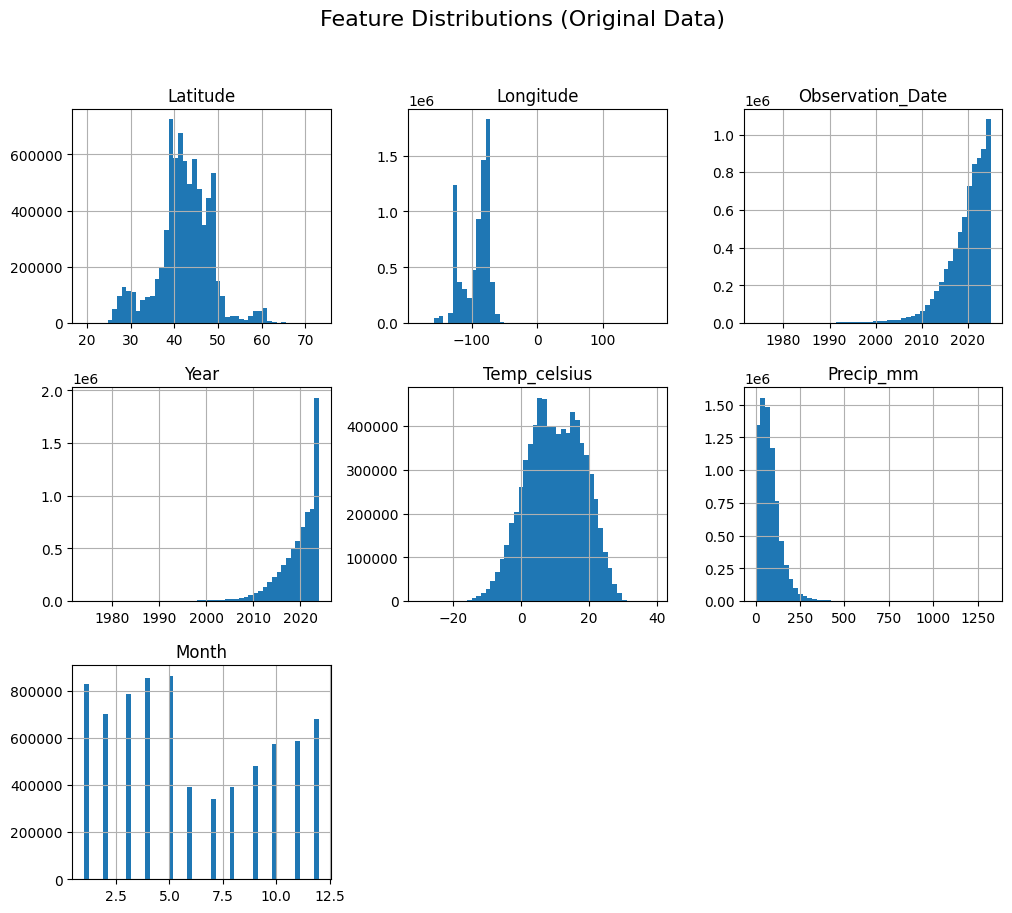

In [ ]:
#plotting variables to see distribution
import matplotlib.pyplot as plt

df.hist(figsize=(12, 10), bins=50)
plt.suptitle("Feature Distributions (Original Data)", fontsize=16)
plt.show()

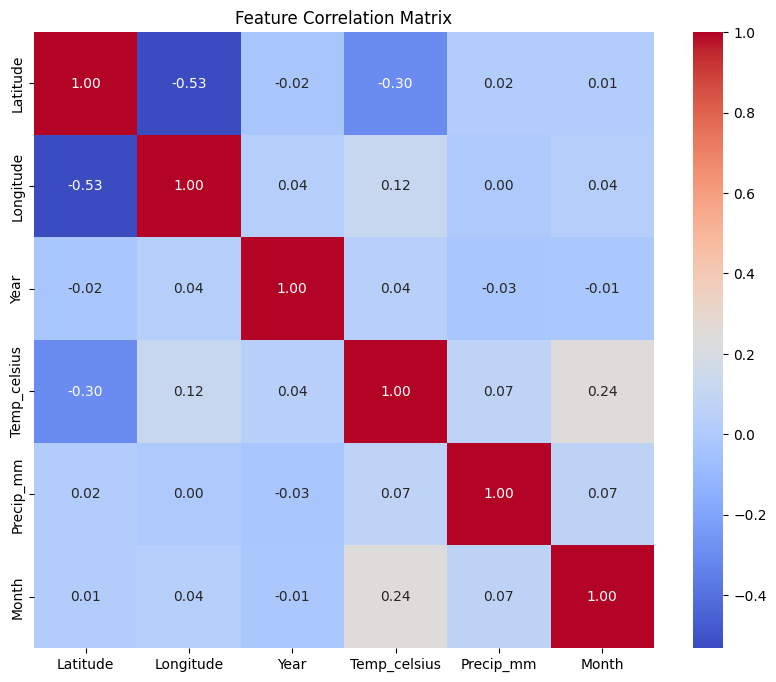

In [ ]:
#feature correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numeric columns
numeric_df = df.select_dtypes(include=["number"])

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


#Assign Sample Weights (Inverse Frequency of Year) to account for imbalance in observations by year**
year_counts = df['Year'].value_counts().to_dict()
df['sample_weight'] = df['Year'].map(lambda y: 1 / year_counts[y])
df["Month"] = df["Month"].astype(int)

# Transformer for Relative Year (Years since first observation)
def relative_year(df):
    """Converts Year to Years Since First Observation."""
    return df[['Year']] - df[['Year']].min()

In [ ]:
# New Time-Based Train-Test Split (Last 3 Years as Test)
split_years = [2021, 2022, 2023, 2024]
final_test_df = df[df["Year"].isin(split_years)]  # Test set: 2021-2023
train_df = df[~df["Year"].isin(split_years)]  # Train set: Everything else

In [ ]:
from sklearn.utils import resample

# Define threshold year
threshold_year = 2017  # Keep 2017-2020 controlled

# Split training data
latest_years = train_df[train_df["Year"] >= threshold_year]
older_years = train_df[train_df["Year"] < threshold_year]

# **Set Downsampling Targets**
max_mid_recent_size = 275_000   # 2017-2019 target size
min_recent_size = 200_000       # 2020 target size

# **Downsample each recent year separately**
downsampled_recent_years = []
for year in latest_years["Year"].unique():
    subset = latest_years[latest_years["Year"] == year]

    if year in [2017, 2018, 2019]:  # Gradually downsample these years
        n_samples = min(max_mid_recent_size, len(subset))
    elif year == 2020:  # 2020 strict cap
        n_samples = min(min_recent_size, len(subset))
    else:
        n_samples = len(subset)  # Do not modify other years

    downsampled_subset = resample(
        subset,
        replace=False,
        n_samples=n_samples,
        random_state=42
    )
    downsampled_recent_years.append(downsampled_subset)

#Combine the Balanced Train Data**
train_df_balanced = pd.concat([older_years] + downsampled_recent_years)

#Verify the New Train-Test Split**
print("Original Training Set Size:", len(train_df))
print("Balanced Training Set Size:", len(train_df_balanced))

# **Check new year distribution**
print(train_df_balanced["Year"].value_counts().sort_index())

Original Training Set Size: 3846094
Balanced Training Set Size: 2683670
Year
1974       466
1975       435
1976       747
1977       639
1978       900
1979       863
1980      1233
1981      1128
1982      1425
1983      1290
1984      1340
1985      1412
1986      2258
1987      2360
1988      2712
1989      3158
1990      3229
1991      3619
1992      4167
1993      4920
1994      4691
1995      5647
1996      5842
1997      6806
1998      7556
1999      8675
2000     10021
2001     10411
2002     12862
2003     15516
2004     18275
2005     19946
2006     25705
2007     33184
2008     40506
2009     54272
2010     74351
2011     97069
2012    138854
2013    180257
2014    231623
2015    276562
2016    341738
2017    275000
2018    275000
2019    275000
2020    200000
Name: count, dtype: int64


In [ ]:
# **Compute Relative Year Before Dropping 'Year'**
train_df_balanced["year_relative"] = train_df_balanced["Year"] - train_df_balanced["Year"].min()
final_test_df["year_relative"] = final_test_df["Year"] - train_df_balanced["Year"].min()  # Keep same reference

<ipython-input-9-5b13e643eb5c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_test_df["year_relative"] = final_test_df["Year"] - train_df_balanced["Year"].min()  # Keep same reference


In [ ]:
# Define X, y, and sample weights for training and final test sets.
# Note: 'Month' is the target variable.

df = df.drop(columns=["Observation_Date"])
X_train = train_df_balanced.drop(columns=['Season', 'sample_weight', 'Year', 'Month'])
y_train = train_df_balanced['Season']
weights_train = train_df_balanced['sample_weight']


X_final_test = final_test_df.drop(columns=['Season', 'sample_weight', 'Year', 'Month'])
y_final_test = final_test_df['Season']
weights_final_test = final_test_df['sample_weight']

In [ ]:
from sklearn.preprocessing import LabelEncoder

#LABEL ENCODING
# Reset and re-encode
le = LabelEncoder()
y_train = le.fit_transform(train_df_balanced['Season'])  # should give 0–3
y_final_test = le.transform(final_test_df['Season'])

print("Encoded labels (train):", np.unique(y_train))  # should be [0, 1, 2, 3]

Encoded labels (train): [0 1 2 3]


In [ ]:
print("Unique y_train:", np.unique(y_train))
print("Label mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

Unique y_train: [0 1 2 3]
Label mapping: {'Fall': np.int64(0), 'Spring': np.int64(1), 'Summer': np.int64(2), 'Winter': np.int64(3)}


In [ ]:
from geopy.distance import great_circle

# Compute the reference point (mean latitude/longitude)
ref_point = (df["Latitude"].mean(), df["Longitude"].mean())

# Function to compute distance
def compute_distance(df):
    return np.array([
        great_circle((lat, lon), ref_point).km
        for lat, lon in zip(df["Latitude"], df["Longitude"])
    ]).reshape(-1, 1)  # Ensure it's a 2D array

In [ ]:
# Create transformers
num_transformer = StandardScaler()
cat_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')
distance_transformer = FunctionTransformer(compute_distance, validate=False)
relative_year_transformer = FunctionTransformer(lambda df: df[['year_relative']], validate=False)

In [ ]:
numerical_features = ['Latitude', 'Longitude', 'Temp_celsius', 'Precip_mm']
categorical_features = ['Region', 'Land_Cover_Description', 'Has_Habitat_Change']


preprocessor = ColumnTransformer([
    ('distance', distance_transformer, ['Latitude', 'Longitude']),
    ('num', num_transformer, numerical_features),
    ('cat', cat_transformer, categorical_features),
    ('year_relative', relative_year_transformer, ['year_relative'])
])

In [ ]:
# Sort data by Year to ensure correct chronological order
df = df.sort_values(by='Year')

In [ ]:
# Fit the preprocessor on the training set and transform both sets
X_train_transformed = preprocessor.fit_transform(X_train)
X_final_test_transformed = preprocessor.transform(X_final_test)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

#CLASS WEIGHTS
computed_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weight_dict = {int(cls): float(wt) for cls, wt in zip(np.unique(y_train), computed_weights)}

In [ ]:
#regular baseline model
import lightgbm as lgb
import joblib
from sklearn.metrics import classification_report

# **Define and Train the Baseline LightGBM Model**
baseline_model = lgb.LGBMClassifier(
    objective="multiclass",
    num_class=num_classes,
    class_weight=class_weight_dict,
    metric="multi_error",
    random_state=42
)

# **Train baseline model without hyperparameter tuning**
baseline_model.fit(X_train_transformed, y_train)

# **Save Baseline Model**
baseline_model_path = "/content/drive/MyDrive/baseline_lightgbm_classifier.pkl"
joblib.dump(baseline_model, baseline_model_path)
print(f"Baseline model saved to {baseline_model_path}")

# **Make Predictions Using Baseline Model**
y_train_pred_baseline = baseline_model.predict(X_train_transformed)
y_final_pred_baseline = baseline_model.predict(X_final_test_transformed)

# **Compare Performance (Baseline vs. Tuned Model)**
print("\n**Baseline LightGBM Model Performance:**")
print("\n **Train Set Performance:**")
print(classification_report(y_train, y_train_pred_baseline))

print("\n **Test Set Performance:**")
print(classification_report(y_final_test, y_final_pred_baseline))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.109751 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1358
[LightGBM] [Info] Number of data points in the train set: 2683670, number of used features: 24
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Baseline model saved to /content/drive/MyDrive/baseline_lightgbm_classifier.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



**Baseline LightGBM Model Performance:**

 **Train Set Performance:**
              precision    recall  f1-score   support

           0       0.65      0.59      0.62    600727
           1       0.76      0.69      0.72    874760
           2       0.84      0.95      0.89    403016
           3       0.84      0.94      0.89    805167

    accuracy                           0.78   2683670
   macro avg       0.77      0.79      0.78   2683670
weighted avg       0.77      0.78      0.77   2683670


 **Test Set Performance:**
              precision    recall  f1-score   support

           0       0.42      0.52      0.46    777489
           1       0.71      0.48      0.57   1253169
           2       0.79      0.94      0.86    552203
           3       0.83      0.90      0.87   1069881

    accuracy                           0.68   3652742
   macro avg       0.69      0.71      0.69   3652742
weighted avg       0.69      0.68      0.68   3652742



In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 14.5 MB/s eta 0:00:00


In [ ]:
pip install optuna-integration[lightgbm]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.6/97.6 kB 4.1 MB/s eta 0:00:00


In [ ]:
 # Import make_scorer from the correct module
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.utils import resample

# Reduce dataset size while preserving class balance
X_train_subset, y_train_subset = resample(
    X_train_transformed, y_train,
    n_samples=int(0.10 * len(X_train_transformed)),
    stratify=y_train,
    random_state=42
)

In [ ]:
import optuna
import lightgbm as lgb
import numpy as np
from optuna.integration.lightgbm import LightGBMPruningCallback
from sklearn.metrics import accuracy_score
from sklearn.model_selection import TimeSeriesSplit



# Define hyperparameter tuning function
def objective(trial):
    params = {
        "objective": "multiclass",
        "num_class": num_classes,
        "metric": "multi_error",
        "learning_rate": trial.suggest_float("learning_rate", 0.02, 0.04, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 30, 50),
        "max_depth": trial.suggest_int("max_depth", 6, 10),
        "n_estimators": trial.suggest_int("n_estimators", 300, 500),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.75, 0.85),
        "subsample": trial.suggest_float("subsample", 0.6, 0.8),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 100, 500),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.1, 2),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.1, 2),
        "class_weight": class_weight_dict,
        "verbosity": -1
    }

    model = lgb.LGBMClassifier(**params)
    tscv = TimeSeriesSplit(n_splits=3)

    accuracy_scores = cross_val_score(model, X_train_subset, y_train_subset, cv=tscv,
                                      scoring="accuracy", n_jobs=-1)
    return accuracy_scores.mean()

# Set Optuna to **maximize accuracy**
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10, n_jobs=1)  # Faster tuning using subset

print("Best hyperparameters:", study.best_params)

[I 2025-04-05 21:55:54,744] A new study created in memory with name: no-name-04ebff16-181c-4a5d-8655-30c6e7b8a25c
[I 2025-04-05 21:56:57,777] Trial 0 finished with value: 0.7660789077521576 and parameters: {'learning_rate': 0.03211600247328405, 'num_leaves': 37, 'max_depth': 9, 'n_estimators': 327, 'colsample_bytree': 0.7632499370059442, 'subsample': 0.6914391148924923, 'min_data_in_leaf': 468, 'reg_lambda': 1.3120513504908276, 'reg_alpha': 1.1051558236231367}. Best is trial 0 with value: 0.7660789077521576.
[I 2025-04-05 21:58:02,435] Trial 1 finished with value: 0.7608819861581037 and parameters: {'learning_rate': 0.03974926305756665, 'num_leaves': 31, 'max_depth': 7, 'n_estimators': 315, 'colsample_bytree': 0.8227929995483982, 'subsample': 0.6492540199628235, 'min_data_in_leaf': 421, 'reg_lambda': 1.4055868266156928, 'reg_alpha': 0.8270021842057776}. Best is trial 0 with value: 0.7660789077521576.
[I 2025-04-05 21:59:07,811] Trial 2 finished with value: 0.7477555360132756 and parame

Best hyperparameters: {'learning_rate': 0.025936036055752686, 'num_leaves': 50, 'max_depth': 10, 'n_estimators': 433, 'colsample_bytree': 0.7882317845350837, 'subsample': 0.7668073730587798, 'min_data_in_leaf': 449, 'reg_lambda': 0.565488606863056, 'reg_alpha': 0.8089781493310441}


In [ ]:
import joblib


# Train the final model with best parameters
best_params = study.best_params
print("Best parameters:", best_params)

# **Train Final LGBM Classifier Model**
best_model = lgb.LGBMClassifier(**best_params, class_weight=class_weight_dict)
best_model.fit(X_train_transformed, y_train)

# **Save Model**
model_path = "/content/drive/MyDrive/best_lightgbm_classifier.pkl"
joblib.dump(best_model, model_path)

print(f"Model saved to {model_path}")

Best parameters: {'learning_rate': 0.025936036055752686, 'num_leaves': 50, 'max_depth': 10, 'n_estimators': 433, 'colsample_bytree': 0.7882317845350837, 'subsample': 0.7668073730587798, 'min_data_in_leaf': 449, 'reg_lambda': 0.565488606863056, 'reg_alpha': 0.8089781493310441}


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=449, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=449
[LightGBM] [Warning] min_data_in_leaf is set=449, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=449
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.109713 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1356
[LightGBM] [Info] Number of data points in the train set: 2683670, number of used features: 23
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Model saved to /content/drive/MyDrive/best_lightgbm_classifier.pkl


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# ========== Logistic Regression Tuning ==========
logistic = LogisticRegression()
logistic_params = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['lbfgs', 'saga'],
    'max_iter': [300]
}

logistic_grid = GridSearchCV(logistic, param_grid=logistic_params, cv=3, scoring='accuracy', n_jobs=-1)
logistic_grid.fit(X_train_transformed, y_train)
best_logistic = logistic_grid.best_estimator_
print("Best Logistic Regression Params:", logistic_grid.best_params_)

Best Logistic Regression Params: {'C': 10, 'max_iter': 300, 'solver': 'saga'}


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [ ]:
from xgboost import XGBClassifier

# ========== XGBoost Tuning ==========
xgb = XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42)
xgb_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
}



# Fit GridSearchCV using the modified y_train_xgb
xgb_grid = GridSearchCV(xgb, param_grid=xgb_params, cv=3, scoring='accuracy', n_jobs=-1)
xgb_grid.fit(X_train_transformed, y_train)

best_xgb = xgb_grid.best_estimator_
print("Best XGBoost Params:", xgb_grid.best_params_)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:23:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best XGBoost Params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}


In [ ]:
# === Stacking Classifier ===
from sklearn.ensemble import StackingClassifier

meta_model = LogisticRegression(max_iter=1000, solver='saga')

stacked_model = StackingClassifier(
    estimators=[
        ('lightgbm', lgb.LGBMClassifier(**best_params, class_weight=class_weight_dict, random_state=42)),
        ('xgboost', best_xgb),
        ('logistic', best_logistic)
    ],
    final_estimator=meta_model,
    passthrough=False,
    n_jobs=-1
)

# Train stacking model
stacked_model.fit(X_train_transformed, y_train)

# Predict
y_train_pred_stacking = stacked_model.predict(X_train_transformed)
y_final_pred_stacking = stacked_model.predict(X_final_test_transformed)

# Decode numeric labels back to season names for clearer evaluation
y_train_labels = le.inverse_transform(y_train)
y_test_labels = le.inverse_transform(y_final_test)
y_train_pred_labels = le.inverse_transform(y_train_pred_stacking)
y_test_pred_labels = le.inverse_transform(y_final_pred_stacking)

# Evaluate
print("\nClassification Report (Train - Tuned Stacking):")
print(classification_report(y_train_labels, y_train_pred_labels))

print("\nClassification Report (Final Test - Tuned Stacking):")
print(classification_report(y_test_labels, y_test_pred_labels))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=449, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=449


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=449, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=449

Classification Report (Train - Tuned Stacking):
              precision    recall  f1-score   support

        Fall       0.77      0.50      0.61    600727
      Spring       0.72      0.83      0.77    874760
      Summer       0.89      0.93      0.91    403016
      Winter       0.87      0.94      0.90    805167

    accuracy                           0.80   2683670
   macro avg       0.81      0.80      0.80   2683670
weighted avg       0.80      0.80      0.80   2683670


Classification Report (Final Test - Tuned Stacking):
              precision    recall  f1-score   support

        Fall       0.48      0.46      0.47    777489
      Spring       0.69      0.64      0.67   1253169
      Summer       0.83      0.92      0.87    552203
      Winter       0.85      0.90      0.87   1069881

    accuracy                           0.72   3652742
   macro avg

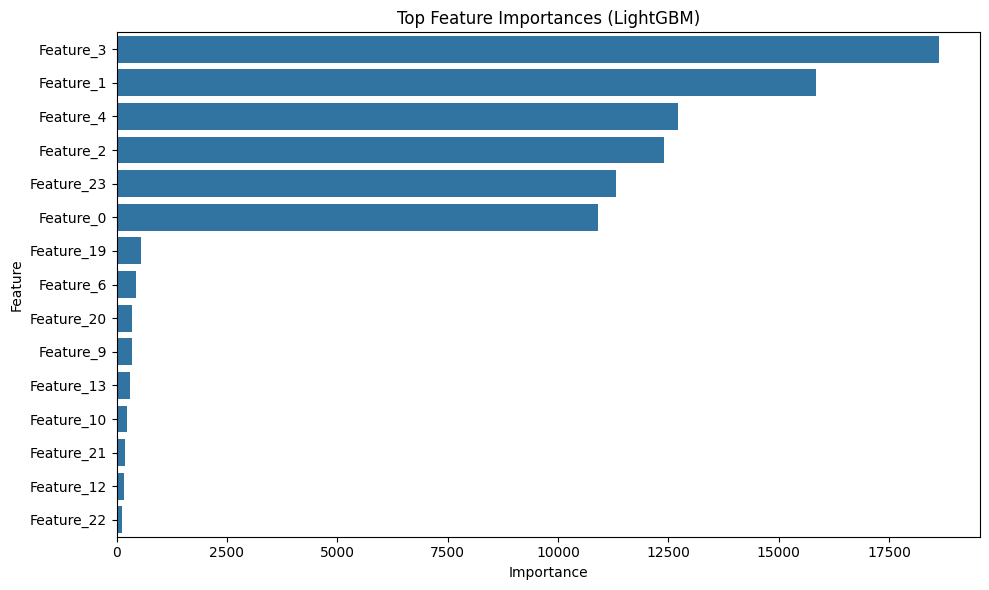

In [ ]:
#looking at feature importance of model
import matplotlib.pyplot as plt

# Season labels from LabelEncoder
season_labels = le.classes_

#Feature Importance Chart from LightGBM
def plot_feature_importance(model, top_n=15):
    importance = model.feature_importances_
    feature_names = [f'Feature_{i}' for i in range(len(importance))]

    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
    importance_df = importance_df.sort_values(by='Importance', ascending=False).head(top_n)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=importance_df, x='Importance', y='Feature')
    plt.title('Top Feature Importances (LightGBM)')
    plt.tight_layout()
    plt.show()

plot_feature_importance(best_model)

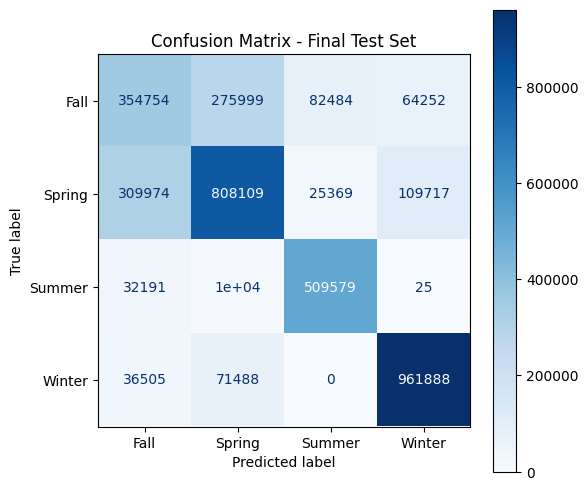

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#Confusion Matrix
def plot_confusion_matrix(true, pred, labels):
    cm = confusion_matrix(true, pred)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#Confusion Matrix
def plot_confusion_matrix(true, pred, labels):
    cm = confusion_matrix(true, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    fig, ax = plt.subplots(figsize=(6, 6))
    disp.plot(ax=ax, cmap='Blues')
    plt.title("Confusion Matrix - Final Test Set")
    plt.show()

plot_confusion_matrix(y_final_test, y_final_pred_stacking, labels=season_labels)

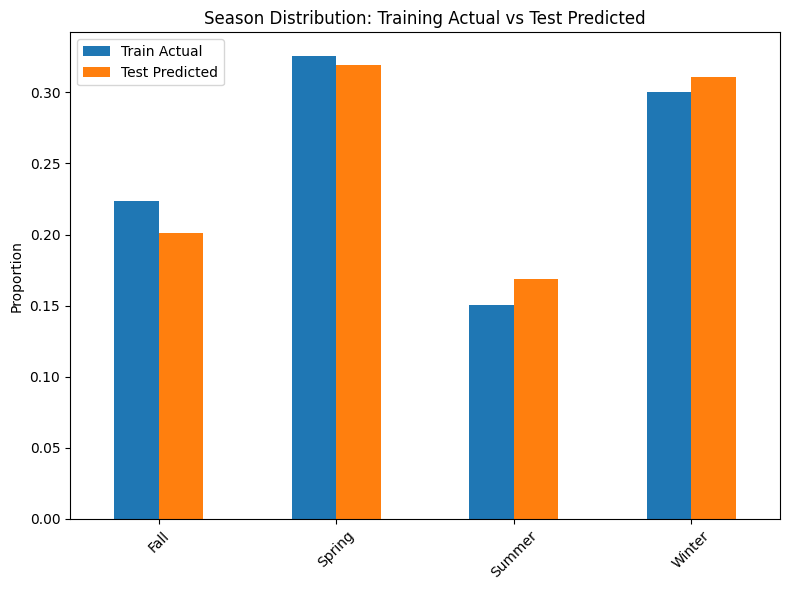

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Distribution: Target (Train) vs Predicted (Test)
def plot_target_vs_pred_distribution(y_train, y_test_pred, le):
    # Convert integers to season names using LabelEncoder
    train_labels = le.inverse_transform(y_train)
    test_pred_labels = le.inverse_transform(y_test_pred)

    train_counts = pd.Series(train_labels).value_counts(normalize=True).sort_index()
    pred_counts = pd.Series(test_pred_labels).value_counts(normalize=True).sort_index()

    df_compare = pd.DataFrame({
        'Train Actual': train_counts,
        'Test Predicted': pred_counts
    })

    df_compare.plot(kind='bar', figsize=(8, 6))
    plt.title('Season Distribution: Training Actual vs Test Predicted')
    plt.ylabel('Proportion')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Call the function using the LabelEncoder
plot_target_vs_pred_distribution(y_train, y_final_pred_stacking, le)

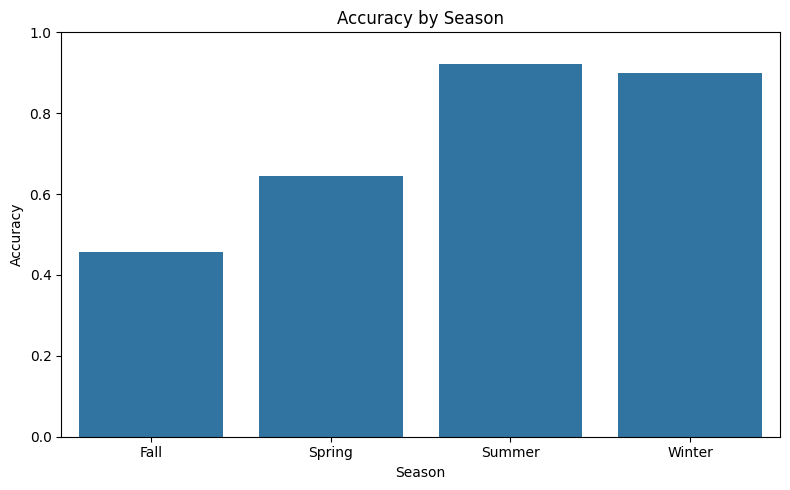

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix

#Accuracy by Season Bar Chart
def plot_accuracy_by_season(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    correct_preds = np.diag(cm)
    totals = cm.sum(axis=1)
    accuracy_per_class = correct_preds / totals

    df_acc = pd.DataFrame({
        'Season': labels,
        'Accuracy': accuracy_per_class
    })

    plt.figure(figsize=(8, 5))
    sns.barplot(data=df_acc, x='Season', y='Accuracy')
    plt.title('Accuracy by Season')
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

plot_accuracy_by_season(y_final_test, y_final_pred_stacking, labels=season_labels)

In [ ]:
# **Check for Overlapping Observations Between Train & Test**
overlap_check = train_df.merge(final_test_df, on=["Latitude", "Longitude", "Observation_Date"], how="inner")

print(f"Number of location-date overlaps after fixing: {len(overlap_check)}")  # Should be 0

Number of location-date overlaps after fixing: 0


In [ ]:
print("Train Set Years:", train_df["Year"].min(), "to", train_df["Year"].max())
print("Test Set Years:", final_test_df["Year"].min(), "to", final_test_df["Year"].max())

Train Set Years: 1974 to 2020
Test Set Years: 2021 to 2024


In [ ]:
train_event_groups = set(train_df[["Latitude", "Longitude", "Observation_Date"]].apply(tuple, axis=1))
test_event_groups = set(final_test_df[["Latitude", "Longitude", "Observation_Date"]].apply(tuple, axis=1))

# Find intersection of event groups
overlapping_groups = train_event_groups & test_event_groups

print(f"Number of shared event groups between Train & Test: {len(overlapping_groups)}")  # Should be 0

Number of shared event groups between Train & Test: 0


In [ ]:
import pandas as pd
import joblib

# Load trained LightGBM model
model_path = "/content/drive/MyDrive/best_lightgbm_classifier.pkl"
best_model = joblib.load(model_path)
print("Model loaded successfully!")

merged_df = pd.read_parquet('/content/drive/MyDrive/merged_bird_climate.parquet')

Model loaded successfully!


In [ ]:
merged_df.head()

,Latitude_x,Longitude_x,Observation_Date,Year,Month,Region,Land_Cover_Description,Has_Habitat_Change,Temp_celsius,Precip_mm,ClimatePeriod,Latitude_y,Longitude_y,SSP,Precipitation,Temp_Mean,Temp_Max,Temp_Min
0,19.3437,-96.4642,2017-10-01,2017,10,Mexico,Cropland/Natural Vegetation Mosaic,False,27.0,234.0,2011-2040,19.4124,-96.6626,ssp126,14.11,24.55,27.55,20.35
1,19.3437,-96.4642,2017-10-01,2017,10,Mexico,Cropland/Natural Vegetation Mosaic,False,27.0,234.0,2011-2040,19.4124,-96.6626,ssp370,13.64,24.65,27.65,20.55
2,19.3437,-96.4642,2017-10-01,2017,10,Mexico,Cropland/Natural Vegetation Mosaic,False,27.0,234.0,2011-2040,19.4124,-96.6626,ssp585,13.44,24.65,27.75,20.45
3,19.3437,-96.4642,2017-10-01,2017,10,Mexico,Cropland/Natural Vegetation Mosaic,False,27.0,234.0,2011-2040,19.4124,-96.6626,ssp126,14.11,24.55,27.55,20.35
4,19.3437,-96.4642,2017-10-01,2017,10,Mexico,Cropland/Natural Vegetation Mosaic,False,27.0,234.0,2011-2040,19.4124,-96.6626,ssp370,13.64,24.65,27.65,20.55


In [ ]:
# Drop historical temperature & precipitation fields (replace with future SSP-based projections)
merged_df.drop(columns=["Latitude_y", "Longitude_y", "Observation_Date"], errors="ignore", inplace=True)

In [ ]:
#rename Latitude_x and Longitude_x to Latitude and Longitude
merged_df = merged_df.rename(columns={'Latitude_x': 'Latitude', 'Longitude_x': 'Longitude'})

In [ ]:
##Replace Historical Climate Data with Future Projections**
## Make sure your future dataset has climate scenario-based columns like "Future_Temp_celsius"
if "Temp_Mean" in merged_df.columns and "Precipitation" in merged_df.columns:
    merged_df.rename(columns={'Temp_Mean': 'Temp_celsius', 'Precipitation': 'Precip_mm'}, inplace=True)
else:
    raise ValueError("Future climate projection data is missing. Ensure 'Temp_Mean' and 'Precipitation' exist.")

In [ ]:
merged_df.drop(columns=["Year"], inplace=True)

In [ ]:
# **1️⃣ Drop the Historical Climate Data (First Occurrence of Temp & Precip)**
merged_df = merged_df.loc[:, ~merged_df.columns.duplicated(keep='last')]

In [ ]:
#using dummy placeholder since trained model had year_relative but I don't want to include that in the data set that we will be making predictions on
merged_df["year_relative"] = 0

In [ ]:
merged_df.head()

,Latitude,Longitude,Month,Region,Land_Cover_Description,Has_Habitat_Change,ClimatePeriod,SSP,Precip_mm,Temp_celsius,Temp_Max,Temp_Min,year_relative
0,19.3437,-96.4642,10,Mexico,Cropland/Natural Vegetation Mosaic,False,2011-2040,ssp126,14.11,24.55,27.55,20.35,0
1,19.3437,-96.4642,10,Mexico,Cropland/Natural Vegetation Mosaic,False,2011-2040,ssp370,13.64,24.65,27.65,20.55,0
2,19.3437,-96.4642,10,Mexico,Cropland/Natural Vegetation Mosaic,False,2011-2040,ssp585,13.44,24.65,27.75,20.45,0
3,19.3437,-96.4642,10,Mexico,Cropland/Natural Vegetation Mosaic,False,2011-2040,ssp126,14.11,24.55,27.55,20.35,0
4,19.3437,-96.4642,10,Mexico,Cropland/Natural Vegetation Mosaic,False,2011-2040,ssp370,13.64,24.65,27.65,20.55,0


In [ ]:
# Apply the same preprocessing as historical data
X_future_transformed = preprocessor.transform(merged_df)

In [ ]:
# Predict Migration Month for Each SSP Scenario
merged_df["Predicted_Season"] = best_model.predict(X_future_transformed)

# Save Predictions for Each SSP
merged_df.to_parquet("predicted_migration_future.parquet", index=False)
print("Future migration predictions saved.")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=449, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=449
Future migration predictions saved.


In [ ]:
#csv conversion
merged_df.to_csv('/content/drive/MyDrive/migration_data.csv', index=False)

In [ ]:
import pandas as pd

# Load predictions
future_preds = pd.read_parquet("predicted_migration_future.parquet")

# Decode Predicted_Season values to actual season names using your LabelEncoder
from sklearn.preprocessing import LabelEncoder

# This must match how you trained your encoder
le = LabelEncoder()
le.fit(['Fall', 'Spring', 'Summer', 'Winter'])  # use the same order used in model training
future_preds['Predicted_Season_Name'] = le.inverse_transform(future_preds['Predicted_Season'])

# Preview
future_preds[['Predicted_Season', 'Predicted_Season_Name']].head()

,Predicted_Season,Predicted_Season_Name
0,1,Spring
1,1,Spring
2,1,Spring
3,1,Spring
4,1,Spring


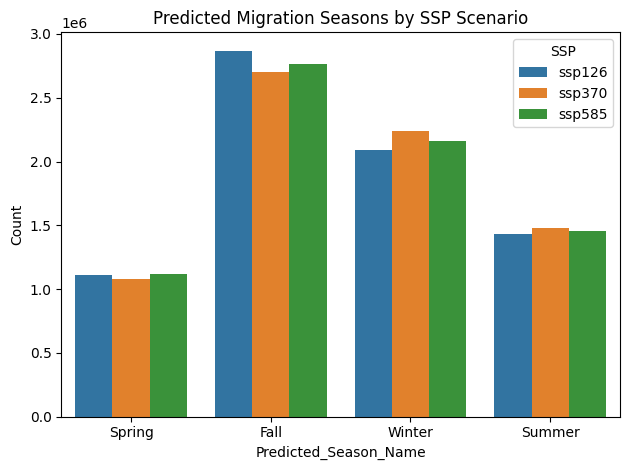

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=future_preds, x="Predicted_Season_Name", hue="SSP")
plt.title("Predicted Migration Seasons by SSP Scenario")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

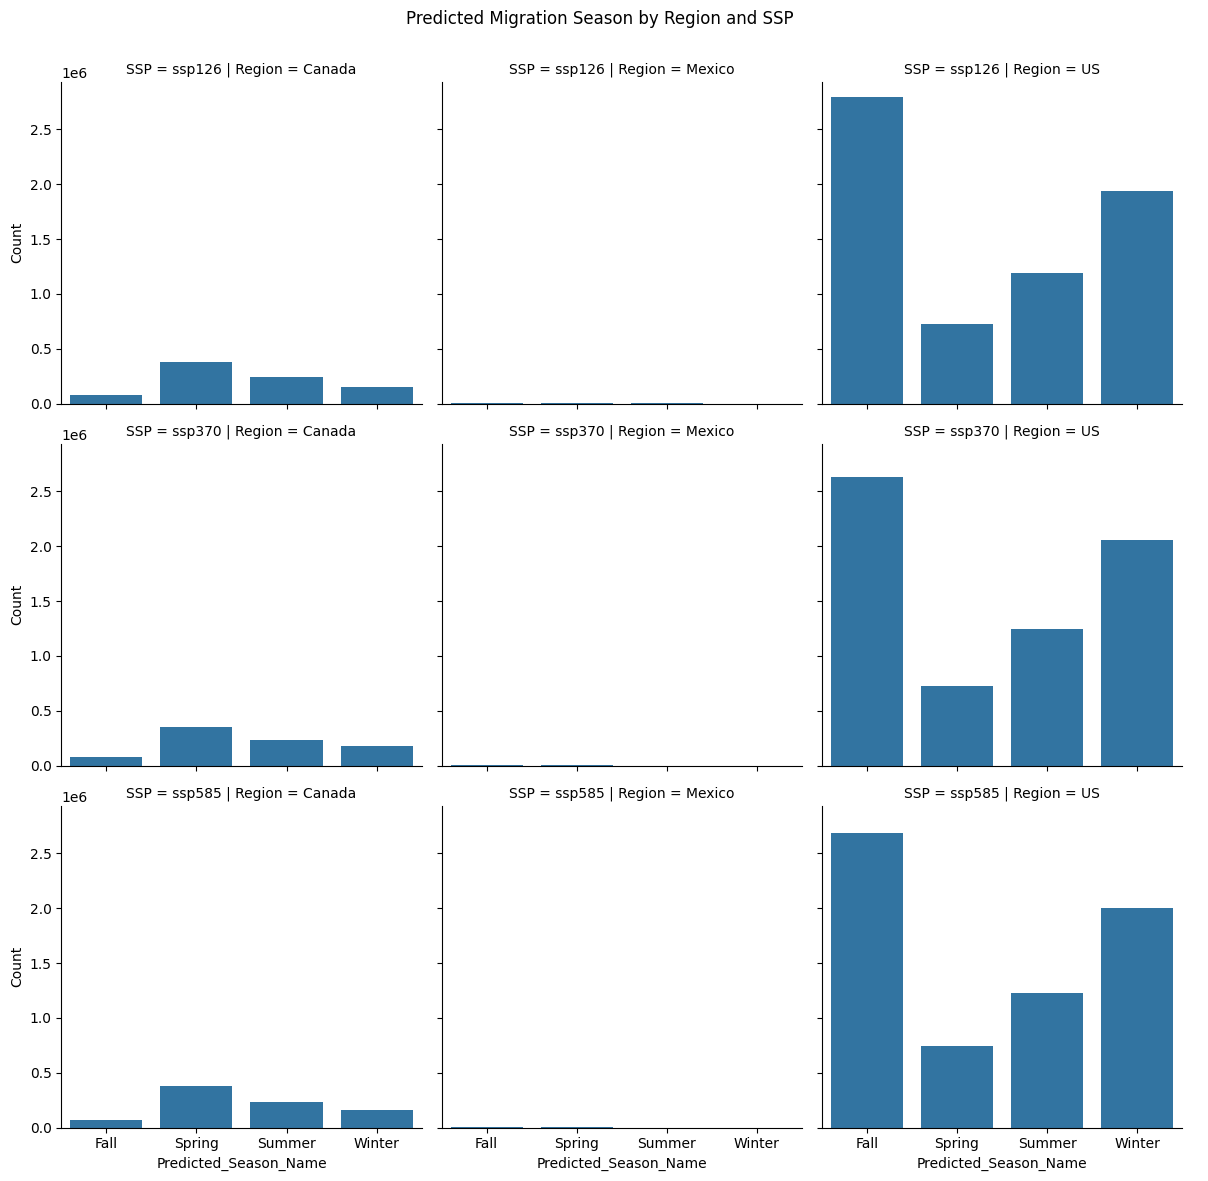

In [ ]:
region_dist_ssp = future_preds.groupby(['Region', 'SSP', 'Predicted_Season_Name']).size().reset_index(name='Count')

sns.catplot(
    data=region_dist_ssp,
    x="Predicted_Season_Name", y="Count",
    col="Region", row="SSP",
    kind="bar", height=4, aspect=1
)

plt.subplots_adjust(top=0.92)
plt.suptitle("Predicted Migration Season by Region and SSP")
plt.show()

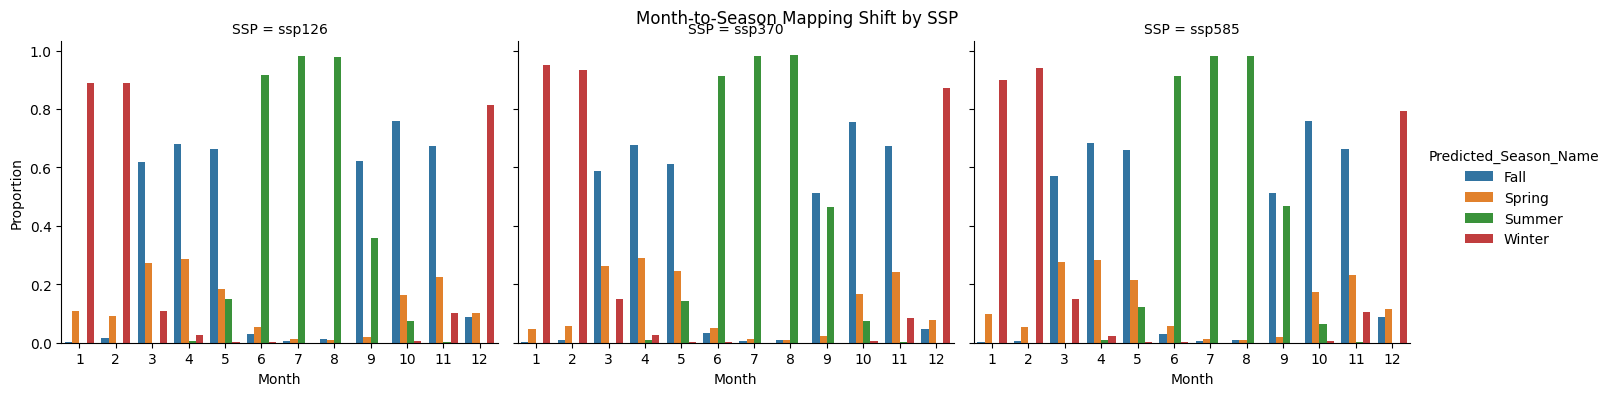

In [ ]:
#Month-to-Season Mapping Shift Visual

monthly_season_shift = future_preds.groupby(['Month', 'SSP', 'Predicted_Season_Name']).size().reset_index(name='Count')
monthly_season_shift['Proportion'] = monthly_season_shift.groupby(['Month', 'SSP'])['Count'].transform(lambda x: x / x.sum())

g = sns.catplot(
    data=monthly_season_shift,
    x='Month', y='Proportion', hue='Predicted_Season_Name',
    col='SSP', kind='bar', col_wrap=3, height=4, aspect=1.2
)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Month-to-Season Mapping Shift by SSP")
plt.show()

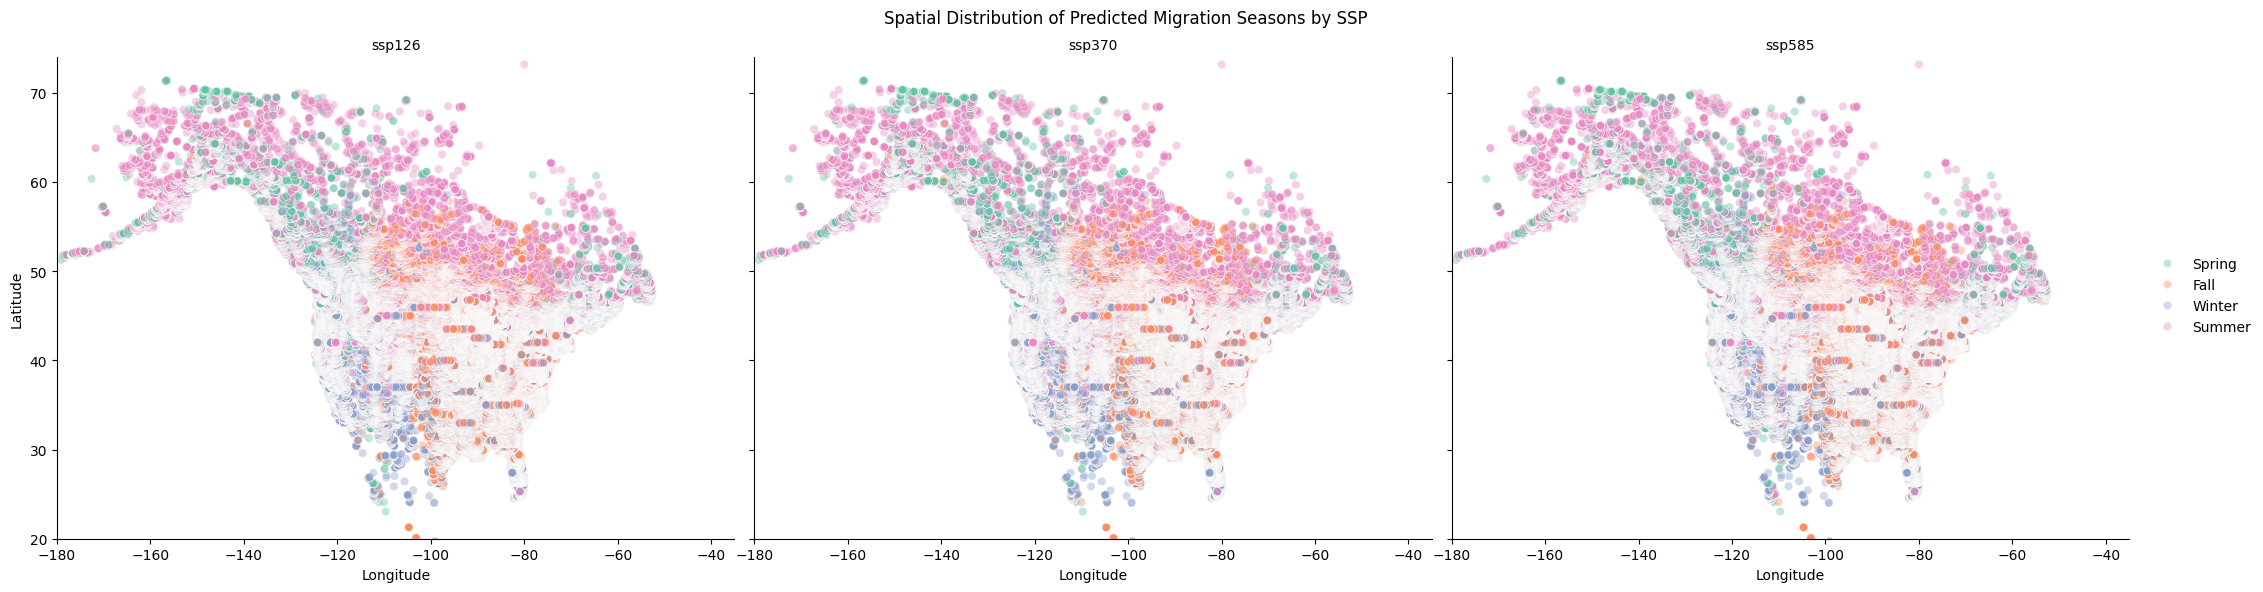

In [ ]:
# Spatial Analysis Visual
import seaborn as sns
import matplotlib.pyplot as plt

g = sns.FacetGrid(
    future_preds,
    col="SSP",
    col_wrap=3,
    height=6,
    aspect=1.2
)

g.map_dataframe(
    sns.scatterplot,
    x="Longitude",
    y="Latitude",
    hue="Predicted_Season_Name",
    alpha=0.4,
    palette="Set2"
)

g.set_titles(col_template="{col_name}")
g.set(xlim=(-180, -35), ylim=(20, 74))  # Optional: adjust based on your data

g.add_legend()
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Spatial Distribution of Predicted Migration Seasons by SSP")
plt.show()

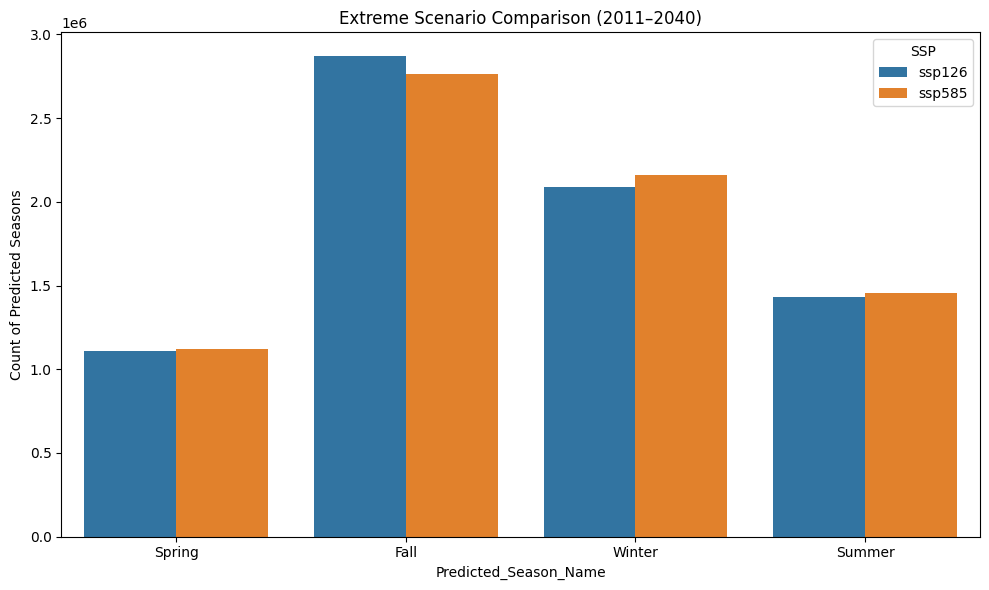

In [ ]:
#Extreme Scenario Comparison (SSP585 vs SSP126)
extreme_subset = future_preds[
    (future_preds['SSP'].isin(['ssp126', 'ssp585'])) &
    (future_preds['ClimatePeriod'] == '2011-2040')
]

plt.figure(figsize=(10, 6))
sns.countplot(data=extreme_subset, x='Predicted_Season_Name', hue='SSP')
plt.title("Extreme Scenario Comparison (2011–2040)")
plt.ylabel("Count of Predicted Seasons")
plt.tight_layout()
plt.show()

<ipython-input-56-ae6f1420917a>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


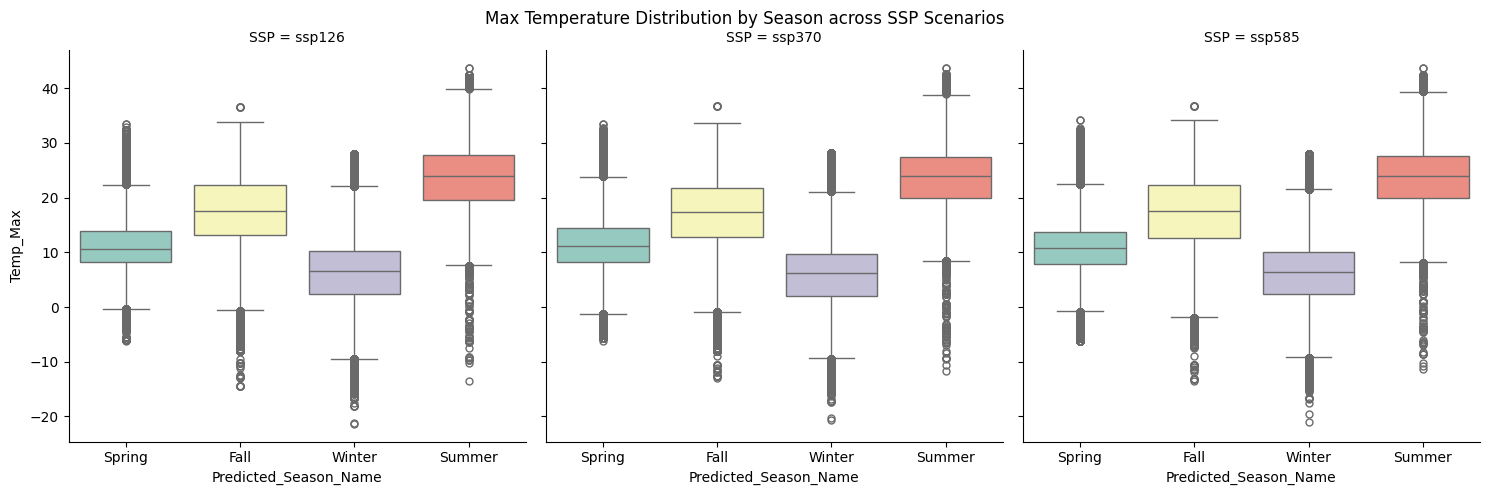

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

g = sns.catplot(
    data=future_preds,
    x='Predicted_Season_Name', y='Temp_Max',
    col='SSP', kind='box', palette='Set3',
    col_wrap=3, height=5, aspect=1
)

g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Max Temperature Distribution by Season across SSP Scenarios")
plt.show()

<ipython-input-57-30379a977d7b>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


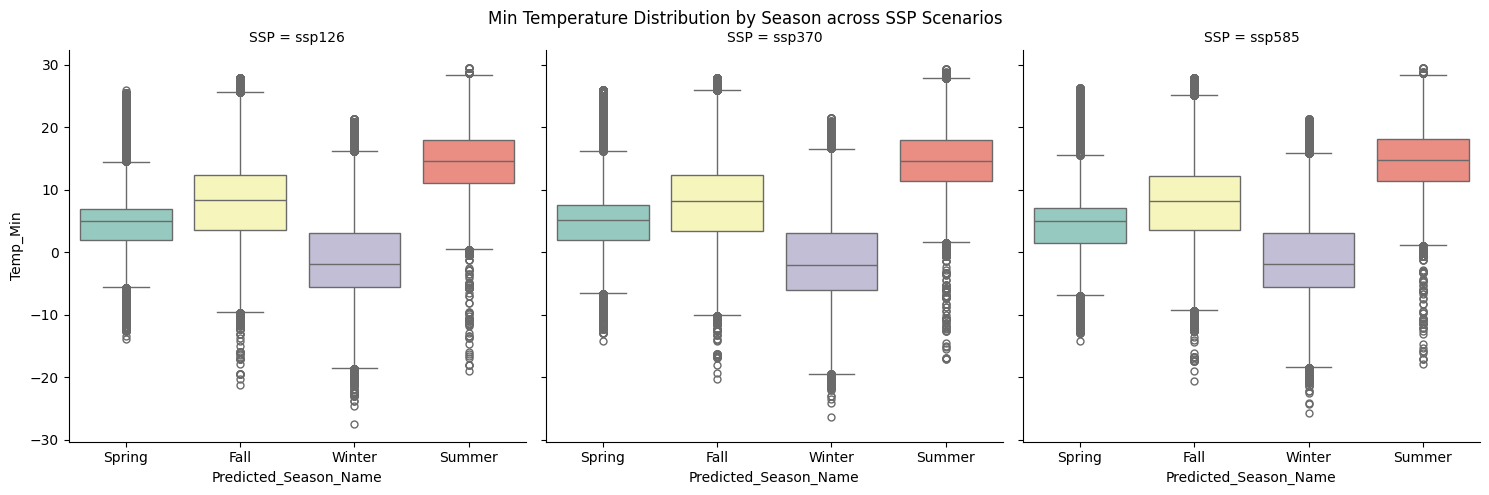

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

g = sns.catplot(
    data=future_preds,
    x='Predicted_Season_Name', y='Temp_Min',
    col='SSP', kind='box', palette='Set3',
    col_wrap=3, height=5, aspect=1
)

g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Min Temperature Distribution by Season across SSP Scenarios")
plt.show()


<ipython-input-58-94a29e24cd4c>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


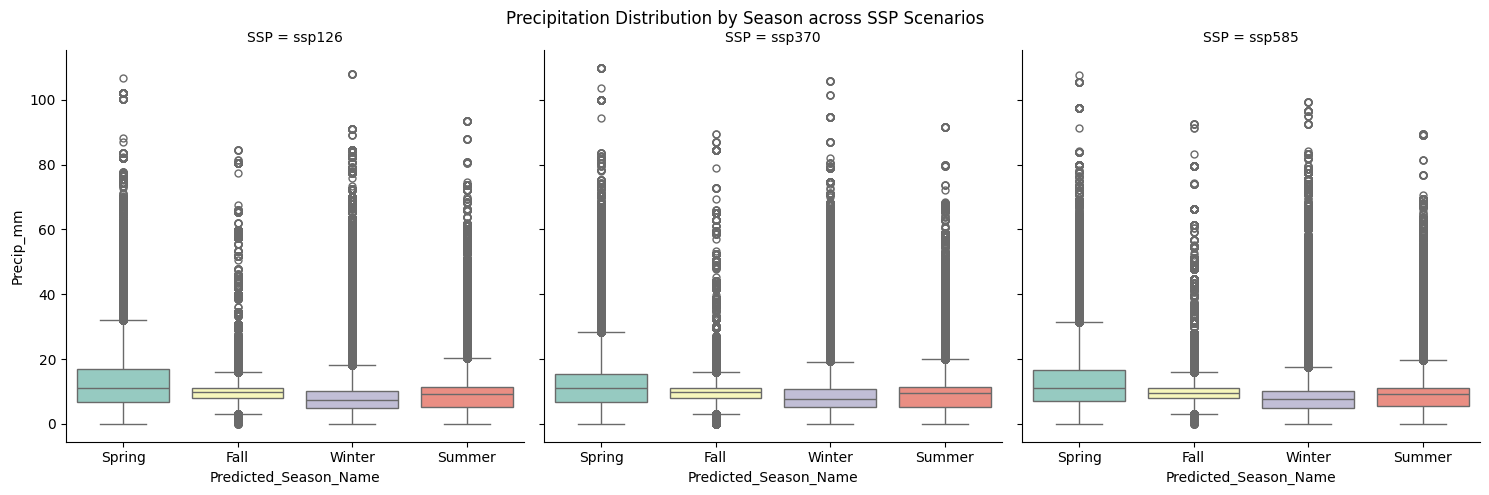

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

g = sns.catplot(
    data=future_preds,
    x='Predicted_Season_Name', y='Precip_mm',
    col='SSP', kind='box', palette='Set3',
    col_wrap=3, height=5, aspect=1
)

g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Precipitation Distribution by Season across SSP Scenarios")
plt.show()

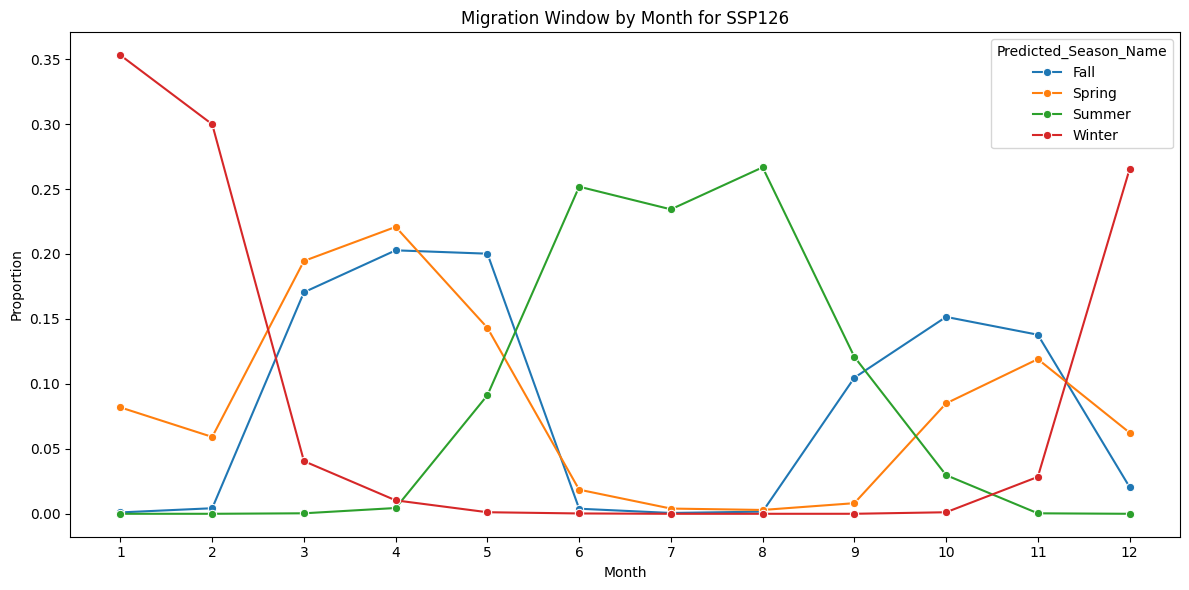

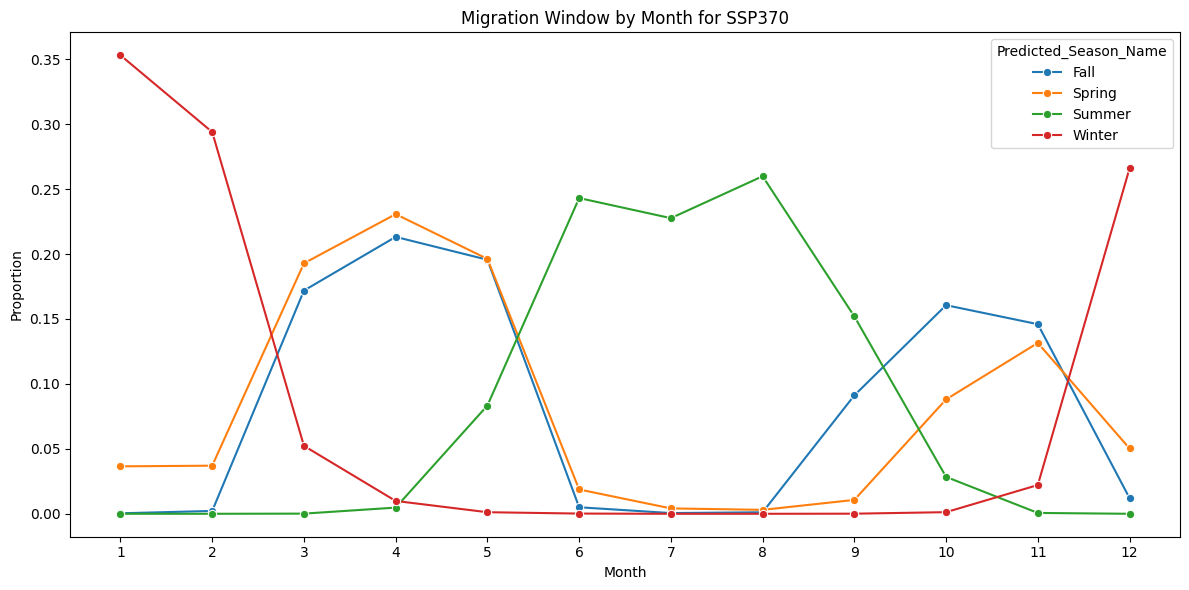

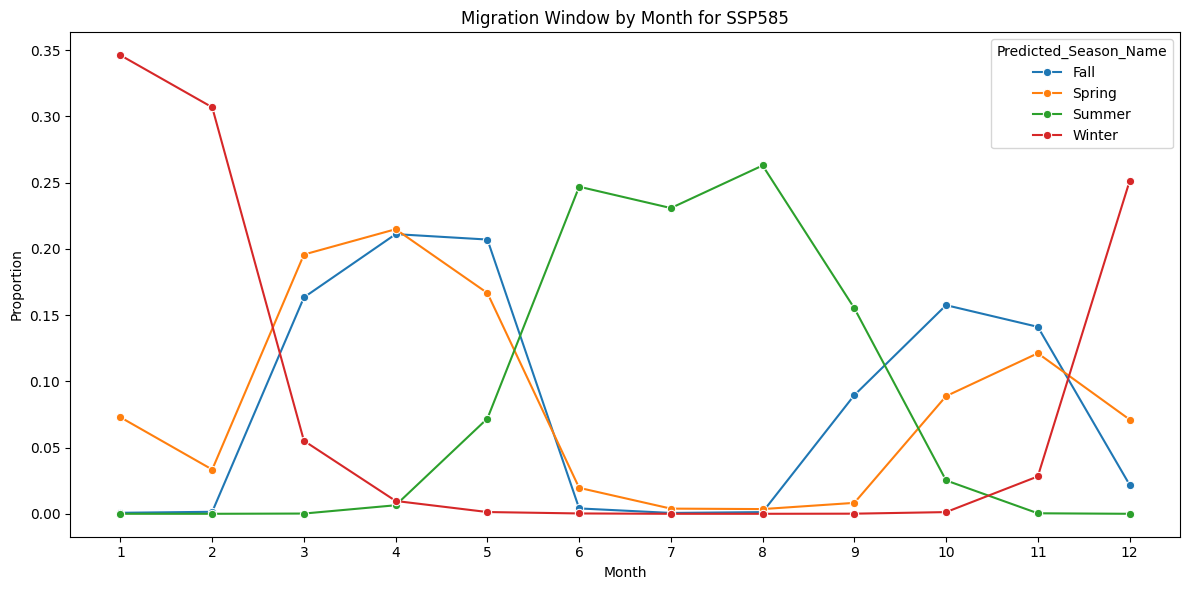

In [ ]:
# Migration Window Visual (Season Spread by Month)
import matplotlib.pyplot as plt
import seaborn as sns

for scenario in ['ssp126', 'ssp370', 'ssp585']:
    subset = future_preds[future_preds['SSP'] == scenario]

    # Recompute monthly proportions per season within this SSP
    window_analysis = subset.groupby(['Predicted_Season_Name', 'Month']).size().reset_index(name='Count')
    window_analysis['Proportion'] = window_analysis.groupby('Predicted_Season_Name')['Count'].transform(lambda x: x / x.sum())

    # Plot
    plt.figure(figsize=(12, 6))
    sns.lineplot(
        data=window_analysis,
        x='Month',
        y='Proportion',
        hue='Predicted_Season_Name',
        marker="o"
    )
    plt.title(f"Migration Window by Month for {scenario.upper()}")
    plt.xticks(ticks=range(1, 13))
    plt.tight_layout()
    plt.show()

In [ ]:
# 1. Overall Summary of Predicted Seasons
season_summary_df = (
    future_preds.groupby(['SSP', 'Predicted_Season_Name'])
    .size()
    .reset_index(name='Count')
)
season_summary_df['Proportion'] = season_summary_df.groupby('SSP')['Count'].transform(lambda x: x / x.sum())

# 2. Season Distribution by Region and SSP
region_season_summary_df = (
    future_preds.groupby(['Region', 'SSP', 'Predicted_Season_Name'])
    .size()
    .reset_index(name='Count')
)
region_season_summary_df['Proportion'] = region_season_summary_df.groupby(['Region', 'SSP'])['Count'].transform(lambda x: x / x.sum())

# 3. Month-to-Season Transition
monthly_season_shift_df = (
    future_preds.groupby(['Month', 'SSP', 'Predicted_Season_Name'])
    .size()
    .reset_index(name='Count')
)
monthly_season_shift_df['Proportion'] = monthly_season_shift_df.groupby(['Month', 'SSP'])['Count'].transform(lambda x: x / x.sum())

# 4. Statistical Summaries for Climate Variables
climate_summary_df = (
    future_preds.groupby(['SSP', 'Predicted_Season_Name']).agg({
        'Temp_Max': ['mean', 'std', 'min', 'max'],
        'Temp_Min': ['mean', 'std', 'min', 'max'],
        'Precip_mm': ['mean', 'std', 'min', 'max']
    }).reset_index()
)
# Flatten multi-level column names
climate_summary_df.columns = ['SSP', 'Season'] + [f"{var}_{stat}" for var, stat in climate_summary_df.columns[2:]]

# 5. Geographic Spread (Centroid and Range)
spatial_summary_df = (
    future_preds.groupby(['SSP', 'Predicted_Season_Name']).agg({
        'Latitude': ['mean', 'std', 'min', 'max'],
        'Longitude': ['mean', 'std', 'min', 'max']
    }).reset_index()
)
spatial_summary_df.columns = ['SSP', 'Season'] + [f"{var}_{stat}" for var, stat in spatial_summary_df.columns[2:]]

# 6. Extreme Scenario Comparison (SSP126 vs SSP585)
extreme_subset = future_preds[
    (future_preds['SSP'].isin(['ssp126', 'ssp585'])) &
    (future_preds['ClimatePeriod'] == '2011-2040')
]
extreme_comparison_df = (
    extreme_subset.groupby(['SSP', 'Predicted_Season_Name'])
    .size()
    .reset_index(name='Count')
)

# 7. Migration Window Summary by Season
window_summary_df = (
    future_preds.groupby(['SSP', 'Predicted_Season_Name', 'Month'])
    .size()
    .reset_index(name='Count')
)
window_summary_df['Proportion'] = window_summary_df.groupby(['SSP', 'Predicted_Season_Name'])['Count'].transform(lambda x: x / x.sum())

In [ ]:
import pandas as pd

# Show all rows and columns when printing
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [ ]:
print("1. Overall Summary of Predicted Seasons")
print(season_summary_df)
print("\n")

print("2. Season Distribution by Region and SSP")
print(region_season_summary_df)
print("\n")

print("3. Month-to-Season Transition")
print(monthly_season_shift_df)
print("\n")

print("4. Climate Variable Summaries (Temp_Max, Temp_Min, Precip_mm)")
print(climate_summary_df)
print("\n")

print("5. Spatial Distribution Summary (Latitude & Longitude)")
print(spatial_summary_df)
print("\n")

print("6. Extreme Scenario Comparison (SSP126 vs SSP585)")
print(extreme_comparison_df)
print("\n")

print("7. Migration Window Summary by Season")
print(window_summary_df)
print("\n")

1. Overall Summary of Predicted Seasons
       SSP Predicted_Season_Name    Count  Proportion
0   ssp126                  Fall  2869390    0.382645
1   ssp126                Spring  1106478    0.147553
2   ssp126                Summer  1433529    0.191167
3   ssp126                Winter  2089439    0.278635
4   ssp370                  Fall  2704784    0.360694
5   ssp370                Spring  1076887    0.143607
6   ssp370                Summer  1477247    0.196997
7   ssp370                Winter  2239918    0.298702
8   ssp585                  Fall  2762315    0.368366
9   ssp585                Spring  1121006    0.149491
10  ssp585                Summer  1456168    0.194186
11  ssp585                Winter  2159347    0.287958


2. Season Distribution by Region and SSP
    Region     SSP Predicted_Season_Name    Count  Proportion
0   Canada  ssp126                  Fall    75357    0.089730
1   Canada  ssp126                Spring   378175    0.450304
2   Canada  ssp126           